In [1]:
from params import *
from data.data import *

import torch 
from torch import nn
import numpy as np

import matplotlib.pyplot as plt
import time
import math

import svgwrite
from IPython.display import SVG, display

In [31]:
def get_bounds(data, factor):
    min_x = 0
    max_x = 0
    min_y = 0
    max_y = 0

    abs_x = 0
    abs_y = 0
    for i in range(len(data)):
        x = float(data[i, 0]) / factor
        y = float(data[i, 1]) / factor
        abs_x += x
        abs_y += y
        min_x = min(min_x, abs_x)
        min_y = min(min_y, abs_y)
        max_x = max(max_x, abs_x)
        max_y = max(max_y, abs_y)

    return (min_x, max_x, min_y, max_y)

# old version, where each path is entire stroke (smaller svg size, but
# have to keep same color)


def draw_strokes(data, factor=10, svg_filename='sample.svg'):
    min_x, max_x, min_y, max_y = get_bounds(data, factor)
    dims = (50 + max_x - min_x, 50 + max_y - min_y)

    dwg = svgwrite.Drawing(svg_filename, size=dims)
    dwg.add(dwg.rect(insert=(0, 0), size=dims, fill='white'))

    lift_pen = 1

    abs_x = 25 - min_x
    abs_y = 25 - min_y
    p = "M%s,%s " % (abs_x, abs_y)

    command = "m"

    for i in range(len(data)):
        if (lift_pen == 1):
            command = "m"
        elif (command != "l"):
            command = "l"
        else:
            command = ""
        x = float(data[i, 0]) / factor
        y = float(data[i, 1]) / factor
        lift_pen = data[i, 2]
        p += command + str(x) + "," + str(y) + " "

    the_color = "black"
    stroke_width = 1

    dwg.add(dwg.path(p).stroke(the_color, stroke_width).fill("none"))

    dwg.save()
    display(SVG(dwg.tostring()))


def draw_strokes_eos_weighted(
        stroke,
        param,
        factor=10,
        svg_filename='sample_eos.svg'):
    c_data_eos = np.zeros((len(stroke), 3))
    for i in range(len(param)):
        # make color gray scale, darker = more likely to eos
        c_data_eos[i, :] = (1 - param[i][6][0]) * 225
    draw_strokes_custom_color(
        stroke,
        factor=factor,
        svg_filename=svg_filename,
        color_data=c_data_eos,
        stroke_width=3)


def draw_strokes_random_color(
        stroke,
        factor=10,
        svg_filename='sample_random_color.svg',
        per_stroke_mode=True):
#     print("storke shape", stroke.shape) # [B, L, 3]
    c_data = np.array(np.random.rand(len(stroke), 3) * 240, dtype=np.uint8)
    if per_stroke_mode:
        switch_color = False
        for i in range(len(stroke)):
            if switch_color == False and i > 0:
                c_data[i] = c_data[i - 1]
            if stroke[i, 2] < 1:  # same strike
                switch_color = False
            else:
                switch_color = True
    draw_strokes_custom_color(
        stroke,
        factor=factor,
        svg_filename=svg_filename,
        color_data=c_data,
        stroke_width=2)


def draw_strokes_custom_color(
        data,
        factor=10,
        svg_filename='test.svg',
        color_data=None,
        stroke_width=1):
    min_x, max_x, min_y, max_y = get_bounds(data, factor)
    dims = (50 + max_x - min_x, 50 + max_y - min_y)

    dwg = svgwrite.Drawing(svg_filename, size=dims)
    dwg.add(dwg.rect(insert=(0, 0), size=dims, fill='white'))

    lift_pen = 1
    abs_x = 25 - min_x
    abs_y = 25 - min_y

    for i in range(len(data)):

        x = float(data[i, 0]) / factor
        y = float(data[i, 1]) / factor

        prev_x = abs_x
        prev_y = abs_y

        abs_x += x
        abs_y += y

        if (lift_pen == 1):
            p = "M " + str(abs_x) + "," + str(abs_y) + " "
        else:
            p = "M +" + str(prev_x) + "," + str(prev_y) + \
                " L " + str(abs_x) + "," + str(abs_y) + " "

        lift_pen = data[i, 2]

        the_color = "black"

        if (color_data is not None):
            the_color = "rgb(" + str(int(color_data[i, 0])) + "," + str(
                int(color_data[i, 1])) + "," + str(int(color_data[i, 2])) + ")"

        dwg.add(dwg.path(p).stroke(the_color, stroke_width).fill(the_color))
    dwg.save()
    display(SVG(dwg.tostring()))

        

In [3]:
class PositionalEncoding(nn.Module):
    "Implement the PE function."
    def __init__(self):
        super(PositionalEncoding, self).__init__()
        max_len = max(MAX_CHAR_LEN, MAX_STROKE_LEN)
        self.dropout = nn.Dropout(p=TF_DROPOUT)

        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, TF_D_MODEL, requires_grad=False)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, TF_D_MODEL, 2) *
                             -(math.log(10000.0) / TF_D_MODEL))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        with torch.no_grad():
            x = x + self.pe[:, :x.size(1)]
            return self.dropout(x)


In [35]:
class TFHW_GMX(nn.Module):
    def __init__(self) -> None:
        super(TFHW_GMX, self).__init__()

        self.src_embed = nn.Sequential(
            nn.Embedding(ALPHABET_SIZE, TF_D_MODEL),
            PositionalEncoding()
        )

        tf_encoder_layer = nn.TransformerEncoderLayer(
            d_model=TF_D_MODEL,
            nhead=TF_N_HEADS,
            dim_feedforward=TF_DIM_FEEDFORWARD,
            batch_first=True,
            dropout=TF_DROPOUT
        )

        self.encoder = nn.TransformerEncoder(
            encoder_layer=tf_encoder_layer,
            num_layers=TF_ENC_LAYERS,
            norm=nn.LayerNorm(TF_D_MODEL)
        )

        self.tgt_embed = nn.Sequential(
            nn.Linear(D_STROKE, TF_D_MODEL),
            PositionalEncoding()
        )

        tf_decoder_layer = nn.TransformerDecoderLayer(
            d_model=TF_D_MODEL,
            nhead=TF_N_HEADS,
            dim_feedforward=TF_DIM_FEEDFORWARD,
            dropout=TF_DROPOUT,
            batch_first=True
        )

        self.decoder = nn.TransformerDecoder(
            decoder_layer=tf_decoder_layer,
            num_layers=TF_DEC_LAYERS,
            norm=nn.LayerNorm(TF_D_MODEL)
        )

        self.z_e = nn.Linear(TF_D_MODEL, 1)
        self.z_pi = nn.Linear(TF_D_MODEL, MX_N_GAUSSIANS)
        self.z_mu1 = nn.Linear(TF_D_MODEL, MX_N_GAUSSIANS)
        self.z_mu2 = nn.Linear(TF_D_MODEL, MX_N_GAUSSIANS)
        self.z_sigma1 = nn.Linear(TF_D_MODEL, MX_N_GAUSSIANS)
        self.z_sigma2 = nn.Linear(TF_D_MODEL, MX_N_GAUSSIANS)
        self.z_rho = nn.Linear(TF_D_MODEL, MX_N_GAUSSIANS)

    def forward(self, batch):

        batch_seq_char = batch['c']
        batch_seq_char_len = batch['c_len']
        batch_seq_stroke = batch['x']
        batch_seq_stroke_len = batch['x_len']

        encode_embed = self.src_embed(batch_seq_char)
        src_key_padding_mask = self.create_pad_mask(encode_embed, batch_seq_char_len)
        encoding = self.encoder(src=encode_embed, src_key_padding_mask=src_key_padding_mask)
        
        return self.decode(encoding, batch_seq_stroke, batch_seq_stroke_len)

    
    def decode(self, encoding, batch_seq_stroke, batch_seq_stroke_len):
    
        decode_embed = self.tgt_embed(batch_seq_stroke)
        tgt_key_padding_mask = self.create_pad_mask(decode_embed, batch_seq_stroke_len)
        tgt_mask = self.create_mask(decode_embed)

        out = self.decoder(
            tgt=decode_embed,
            tgt_mask=tgt_mask,
            memory=encoding,
            tgt_key_padding_mask=tgt_key_padding_mask
        )

        # ===== Computing MDN =====
        es = self.z_e(out)
#         print("es shape ", es.shape) # -> torch.Size([sequence_length, batch, 1])
        es = 1 / (1 + torch.exp(es))
#         print("es shape", es.shape) # -> torch.Size([sequence_length, batch, 1])

        pis = self.z_pi(out)
#         print("pis shape ", pis.shape) # -> torch.Size([sequence_length, batch, n_gaussians])
        pis = torch.softmax(pis, 2)
#         print(pis.shape) # -> torch.Size([sequence_length, batch, n_gaussians])

        mu1s = self.z_mu1(out)
        mu2s = self.z_mu2(out)
#         print("mu shape :  ", mu1s.shape) # -> torch.Size([sequence_length, batch, n_gaussians])

        sigma1s = self.z_sigma1(out)
        sigma2s = self.z_sigma2(out)
#         print("sigmas shape ", sigma1s.shape) # -> torch.Size([sequence_length, batch, n_gaussians])
        sigma1s = torch.exp(sigma1s)
        sigma2s = torch.exp(sigma2s)
#         print(sigma1s.shape) # -> torch.Size([sequence_length, batch, n_gaussians])

        rhos = self.z_rho(out)
        rhos = torch.tanh(rhos)
#         print("rhos shape ", rhos.shape) # -> torch.Size([sequence_length, batch, n_gaussians])

        es = es.squeeze(2)
#         print("es shape ", es.shape) # -> torch.Size([sequence_length, batch])


        return es, pis, mu1s, mu2s, sigma1s, sigma2s, rhos

    def loss_fn(self, Pr, y, es):
        eps = float(np.finfo(np.float32).eps)
        loss1 = - torch.log(Pr + eps) # -> torch.Size([sequence_length, batch])
        bernouilli = torch.zeros_like(es) # -> torch.Size([sequence_length, batch])

        bernouilli = y[:, :, 2] * es + (1 - y[:, :, 2]) * (1 - es)

        loss2 = - torch.log(bernouilli + eps)
        loss = loss1 + loss2
        # print("loss shape", loss.shape) # -> torch.Size([sequence_length, batch])
        loss = torch.sum(loss, 1)
        # print("loss shape", loss.shape) # -> torch.Size([batch])

        return torch.mean(loss);

    def generate_sample(self, mu1, mu2, sigma1, sigma2, rho):
        mean = [mu1, mu2]
        cov = [[sigma1 ** 2, rho * sigma1 * sigma2], [rho * sigma1 * sigma2, sigma2 ** 2]]

        x = np.float32(np.random.multivariate_normal(mean, cov, 1))
        return torch.from_numpy(x)
    

    def generate_sequence(self, x0, c0, bias):
        sequence = x0
        sample = x0
        sequence_length = c0.shape[1] * 25

        print("Generating sequence ...")
        self.bias = bias
        # f = FloatProgress(min=0, max=sequence_length)
        # display(f)
        
        encode_embed = self.src_embed(c0).to(DEVICE)
        src_key_padding_mask = self.create_pad_mask(encode_embed, [len(c0)]).to(DEVICE)
        encoding = self.encoder(src=encode_embed, src_key_padding_mask=src_key_padding_mask).to(DEVICE)

        for i in range(sequence_length):
            es, pis, mu1s, mu2s, sigma1s, sigma2s, rhos = self.decode(encoding, sequence, [sequence_length])

            # Selecting a mixture
            pi_idx = np.random.choice(range(MX_N_GAUSSIANS), p=pis[0, -1, :].detach().cpu().numpy())

            # taking last parameters from sequence corresponding to chosen gaussian
            mu1 = mu1s[:, -1, pi_idx].item()
            mu2 = mu2s[:, -1, pi_idx].item()
            sigma1 = sigma1s[:, -1, pi_idx].item()
            sigma2 = sigma2s[:, -1, pi_idx].item()
            rho = rhos[:, -1, pi_idx].item()

            prediction = self.generate_sample(mu1, mu2, sigma1, sigma2, rho)
            eos = torch.distributions.bernoulli.Bernoulli(torch.tensor([es[:, -1].item()])).sample()

            sample = torch.zeros_like(x0) # torch.Size([1, 1, 3])
            sample[0, 0, 0] = prediction[0, 0]
            sample[0, 0, 1] = prediction[0, 1]
            sample[0, 0, 2] = eos

            sequence = torch.cat((sequence, sample), 1) # torch.Size([sequence_length, 1, 3])

            # f.value += 1

        self.bias = 0

        return sequence.squeeze(1).detach().cpu().numpy()

    def gaussianMixture(self, y, pis, mu1s, mu2s, sigma1s, sigma2s, rhos):
        n_mixtures = pis.size(2)

        # Takes x1 and repeats it over the number of gaussian mixtures
        x1 = y[:,:, 0].repeat(n_mixtures, 1, 1).permute(1, 2, 0)
#         print("x1 shape ", x1.shape) # -> torch.Size([sequence_length, batch, n_gaussians])

        # first term of Z (eq 25)
        x1norm = ((x1 - mu1s) ** 2) / (sigma1s ** 2 )
#         print("x1norm shape ", x1.shape) # -> torch.Size([sequence_length, batch, n_gaussians])

        x2 = y[:,:, 1].repeat(n_mixtures, 1, 1).permute(1, 2, 0)
#         print("x2 shape ", x2.shape) # -> torch.Size([sequence_length, batch, n_gaussians])

        # second term of Z (eq 25)
        x2norm = ((x2 - mu2s) ** 2) / (sigma2s ** 2 )
#         print("x2norm shape ", x2.shape) # -> torch.Size([sequence_length, batch, n_gaussians])

        # third term of Z (eq 25)
        coxnorm = 2 * rhos * (x1 - mu1s) * (x2 - mu2s) / (sigma1s * sigma2s)

        # Computing Z (eq 25)
        Z = x1norm + x2norm - coxnorm

        # Gaussian bivariate (eq 24)
        N = torch.exp(-Z / (2 * (1 - rhos ** 2))) / (2 * np.pi * sigma1s * sigma2s * (1 - rhos ** 2) ** 0.5)
#         print("N shape ", N.shape) # -> torch.Size([sequence_length, batch, n_gaussians])

        # Pr is the result of eq 23 without the eos part
        Pr = pis * N
#         print("Pr shape ", Pr.shape) # -> torch.Size([sequence_length, batch, n_gaussians])
        Pr = torch.sum(Pr, dim=2)
#         print("Pr shape ", Pr.shape) # -> torch.Size([sequence_length, batch])

        return Pr
    
    def create_pad_mask(self, tensor, tensor_len) -> torch.tensor:
        """_summary_

        Args:
            tensor (N, L, ...):
            tensor_len (N,):

        Returns:
            torch.tensor: the pad_mask
        """

        N, L = tensor.shape[0], tensor.shape[1]
        pad_mask = torch.full([N, L], False)
        for i, l in enumerate(tensor_len):
            pad_mask[i, l:] = True

        return pad_mask.to(DEVICE)
    
    def create_mask(self, tensor) -> torch.tensor:
        """_summary_

        Args:
            tensor (N): _description_

        Returns:
            torch.tensor: _description_
        """
        # Generates a squeare matrix where the each row allows one word more to be seen
        L = tensor.shape[1] # seqeunce length
        return torch.triu(torch.full((L, L), float('-inf')), diagonal=1).to(DEVICE)



In [42]:
def train_network(model, epochs = 5, generate = True):
    data_loader = DataReader(PROCESED_DATA_DIR)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)
    
    # A sequence the model is going to try to write as it learns
    c0 = torch.tensor([alpha_to_num[c] for c in "writing is hard!"]) 
    c0 = torch.unsqueeze(c0, 0) # torch.Size(n_batch, U_items, len(alphabet))
    start = time.time()
    
    model = model.to(DEVICE)
    c0 = c0.to(DEVICE)
        
    # Arrays to plot loss over time
    time_batch = []
    time_epoch = [0]
    loss_batch = []
    loss_epoch = []
    
    # Loop over epochs
    for epoch in range(epochs):
        
        # Loop over batches
        for batch, data in enumerate(data_loader.train_batch_generator(BATCH_SIZE)):
            num_batches = int(data_loader.get_train_len() / BATCH_SIZE)
            # Forward pass
            es, pis, mu1s, mu2s, sigma1s, sigma2s, rhos = model.forward(data)
            
            # Calculate probability density and loss
            y = torch.zeros_like(data['x'])
            B, L, _ = y.shape
            y[:, :L - 1, :] = data['x'][:, 1:, :]
            Pr = model.gaussianMixture(y, pis, mu1s, mu2s, sigma1s, sigma2s, rhos)
            loss = model.loss_fn(Pr,y, es)
            
            # Back propagation
            optimizer.zero_grad()
            loss.backward()
            
            # Gradient cliping
            torch.nn.utils.clip_grad_norm_(model.parameters(), GRADIENT_THRESHOLD)
            optimizer.step()
            
            # Useful infos over training
            if batch % 10 == 0:
                print("Epoch : ", epoch, " - step ", batch, "/", num_batches, " - loss ", loss.item(), " in ", time.time() - start)
                start = time.time()
                
                # Plot heatmaps every 100 batch
#                 if batch % 100 == 0:
#                     print(s[0])
                    # plot_heatmaps(model.Phis.transpose(0, 1).detach().numpy(), model.Ws.transpose(0, 1).detach().numpy())
                    
                # Generate a sequence every 500 batch        
                if generate and batch % 500 == 0 :
                    x0 = torch.Tensor([0,0,1]).view(1,1,3).to(DEVICE)

                    
                    for i in range(5):
                        sequence = model.generate_sequence(x0, c0, bias = 10)
#                         print(sequence.shape)
                        draw_strokes_random_color(sequence.squeeze(), factor=0.5)
                    
            # Save loss per batch
            time_batch.append(epoch + batch / num_batches)
            loss_batch.append(loss.item())
        
        # Save loss per epoch
        time_epoch.append(epoch + 1)
        loss_epoch.append(sum(loss_batch[epoch * num_batches : (epoch + 1)*num_batches-1]) / num_batches)
        
        # Save model after each epoch
        torch.save(model.state_dict(), "./saved_models/synthesis.py")
        
    # Plot loss 
    plt.plot(time_batch, loss_batch)
    plt.plot(time_epoch, [loss_batch[0]] + loss_epoch, color="orange", linewidth=5)
    plt.xlabel("Epoch", fontsize=15)
    plt.ylabel("Loss", fontsize=15)
    plt.show()
        

    return model
                


train size 11034
val size 581
test size 11615
Epoch :  0  - step  0 / 344  - loss  4280.81787109375  in  0.9400668144226074
Generating sequence ...
storke shape (401, 3)


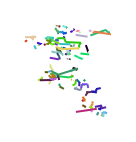

Generating sequence ...
storke shape (401, 3)


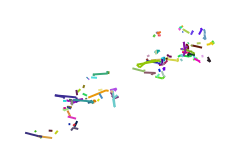

Generating sequence ...
storke shape (401, 3)


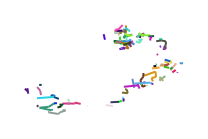

Generating sequence ...
storke shape (401, 3)


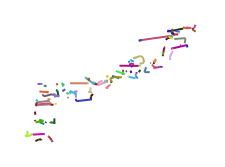

Generating sequence ...
storke shape (401, 3)


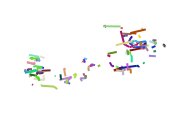

Epoch :  0  - step  10 / 344  - loss  3672.1435546875  in  27.04659104347229
Epoch :  0  - step  20 / 344  - loss  3385.0751953125  in  7.536001682281494
Epoch :  0  - step  30 / 344  - loss  3121.06494140625  in  7.255250453948975
Epoch :  0  - step  40 / 344  - loss  2621.2119140625  in  7.372235059738159
Epoch :  0  - step  50 / 344  - loss  2605.36328125  in  6.498225927352905
Epoch :  0  - step  60 / 344  - loss  2385.70654296875  in  7.125311613082886
Epoch :  0  - step  70 / 344  - loss  2724.677490234375  in  7.908499002456665
Epoch :  0  - step  80 / 344  - loss  2321.61474609375  in  7.320403099060059
Epoch :  0  - step  90 / 344  - loss  2304.822265625  in  8.316486120223999
Epoch :  0  - step  100 / 344  - loss  1916.89453125  in  6.355032205581665
Epoch :  0  - step  110 / 344  - loss  2031.705810546875  in  7.9082276821136475
Epoch :  0  - step  120 / 344  - loss  2067.177001953125  in  7.321917772293091
Epoch :  0  - step  130 / 344  - loss  1708.6513671875  in  7.415330

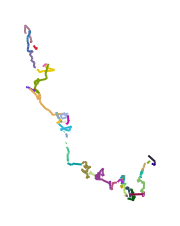

Generating sequence ...
storke shape (401, 3)


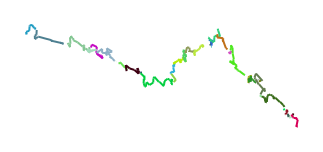

Generating sequence ...
storke shape (401, 3)


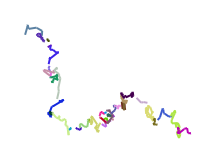

Generating sequence ...
storke shape (401, 3)


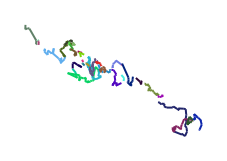

Generating sequence ...
storke shape (401, 3)


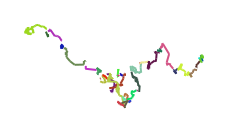

Epoch :  1  - step  10 / 344  - loss  607.827392578125  in  26.777169466018677
Epoch :  1  - step  20 / 344  - loss  855.9173583984375  in  6.758317947387695
Epoch :  1  - step  30 / 344  - loss  1080.08935546875  in  7.9980151653289795
Epoch :  1  - step  40 / 344  - loss  576.2686767578125  in  7.227420091629028
Epoch :  1  - step  50 / 344  - loss  399.1239013671875  in  7.749292850494385
Epoch :  1  - step  60 / 344  - loss  524.8392333984375  in  7.236528635025024
Epoch :  1  - step  70 / 344  - loss  747.93603515625  in  7.1858296394348145
Epoch :  1  - step  80 / 344  - loss  -124.80296325683594  in  8.002621173858643
Epoch :  1  - step  90 / 344  - loss  435.0169677734375  in  7.448532819747925
Epoch :  1  - step  100 / 344  - loss  310.46368408203125  in  7.871201515197754
Epoch :  1  - step  110 / 344  - loss  172.53208923339844  in  7.3521928787231445
Epoch :  1  - step  120 / 344  - loss  713.4962768554688  in  7.606907606124878
Epoch :  1  - step  130 / 344  - loss  73.147

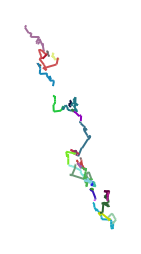

Generating sequence ...
storke shape (401, 3)


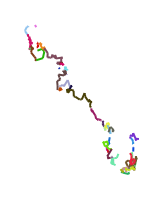

Generating sequence ...
storke shape (401, 3)


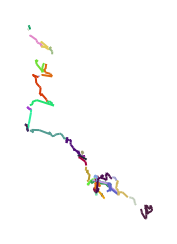

Generating sequence ...
storke shape (401, 3)


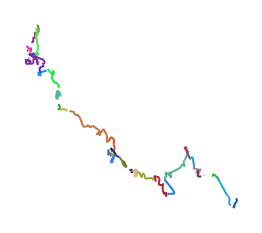

Generating sequence ...
storke shape (401, 3)


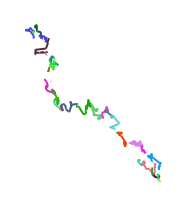

Epoch :  2  - step  10 / 344  - loss  91.53748321533203  in  26.65209150314331
Epoch :  2  - step  20 / 344  - loss  -222.143310546875  in  7.795632600784302
Epoch :  2  - step  30 / 344  - loss  17.590293884277344  in  7.70783257484436
Epoch :  2  - step  40 / 344  - loss  315.8389892578125  in  7.0464160442352295
Epoch :  2  - step  50 / 344  - loss  -702.7271728515625  in  7.709593296051025
Epoch :  2  - step  60 / 344  - loss  425.8121337890625  in  7.4941418170928955
Epoch :  2  - step  70 / 344  - loss  -510.4361877441406  in  7.525263071060181
Epoch :  2  - step  80 / 344  - loss  -1060.446533203125  in  8.136935472488403
Epoch :  2  - step  90 / 344  - loss  -465.58099365234375  in  7.738884210586548
Epoch :  2  - step  100 / 344  - loss  467.5592956542969  in  7.589788913726807
Epoch :  2  - step  110 / 344  - loss  -255.74070739746094  in  6.760435581207275
Epoch :  2  - step  120 / 344  - loss  139.6593017578125  in  7.990736722946167
Epoch :  2  - step  130 / 344  - loss  -

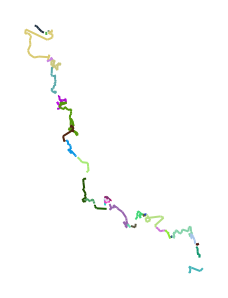

Generating sequence ...
storke shape (401, 3)


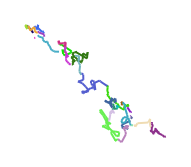

Generating sequence ...
storke shape (401, 3)


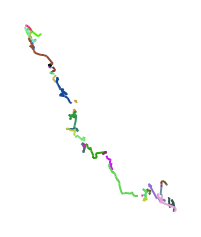

Generating sequence ...
storke shape (401, 3)


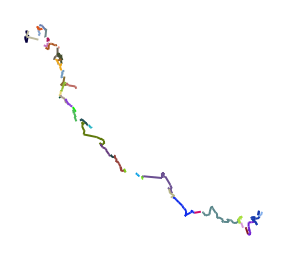

Generating sequence ...
storke shape (401, 3)


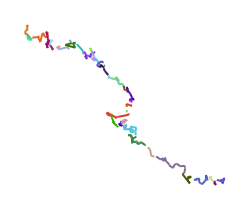

Epoch :  3  - step  10 / 344  - loss  -1184.548095703125  in  26.30107069015503
Epoch :  3  - step  20 / 344  - loss  -307.9046630859375  in  7.7484917640686035
Epoch :  3  - step  30 / 344  - loss  -725.6709594726562  in  7.679928779602051
Epoch :  3  - step  40 / 344  - loss  -202.96234130859375  in  8.15482211112976
Epoch :  3  - step  50 / 344  - loss  29.724275588989258  in  7.2080628871917725
Epoch :  3  - step  60 / 344  - loss  -385.7027587890625  in  6.907533168792725
Epoch :  3  - step  70 / 344  - loss  -385.22686767578125  in  7.260956048965454
Epoch :  3  - step  80 / 344  - loss  -1212.24267578125  in  7.366546154022217
Epoch :  3  - step  90 / 344  - loss  113.24125671386719  in  6.696835994720459
Epoch :  3  - step  100 / 344  - loss  -1119.7664794921875  in  7.670405387878418
Epoch :  3  - step  110 / 344  - loss  -613.44140625  in  7.705268859863281
Epoch :  3  - step  120 / 344  - loss  -1507.524169921875  in  8.059149503707886
Epoch :  3  - step  130 / 344  - loss  

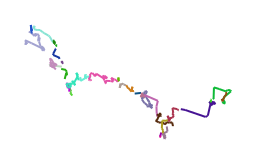

Generating sequence ...
storke shape (401, 3)


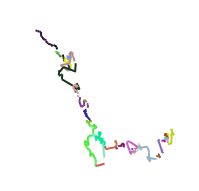

Generating sequence ...
storke shape (401, 3)


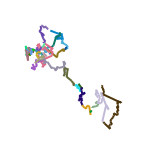

Generating sequence ...
storke shape (401, 3)


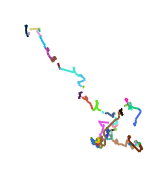

Generating sequence ...
storke shape (401, 3)


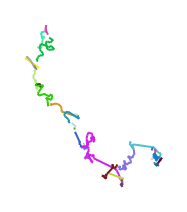

Epoch :  4  - step  10 / 344  - loss  -706.4463500976562  in  27.494977474212646
Epoch :  4  - step  20 / 344  - loss  -585.5291137695312  in  8.359637022018433
Epoch :  4  - step  30 / 344  - loss  464.6006774902344  in  7.686286687850952
Epoch :  4  - step  40 / 344  - loss  -1429.434814453125  in  8.1669340133667
Epoch :  4  - step  50 / 344  - loss  -1148.4422607421875  in  7.44212532043457
Epoch :  4  - step  60 / 344  - loss  271.2188720703125  in  7.261386394500732
Epoch :  4  - step  70 / 344  - loss  -1007.3606567382812  in  7.372915506362915
Epoch :  4  - step  80 / 344  - loss  -1243.22900390625  in  7.060450792312622
Epoch :  4  - step  90 / 344  - loss  -942.552734375  in  7.171115159988403
Epoch :  4  - step  100 / 344  - loss  28.31597900390625  in  7.496275901794434
Epoch :  4  - step  110 / 344  - loss  -1222.5057373046875  in  7.318248987197876
Epoch :  4  - step  120 / 344  - loss  -461.8813781738281  in  6.85000467300415
Epoch :  4  - step  130 / 344  - loss  -122.0

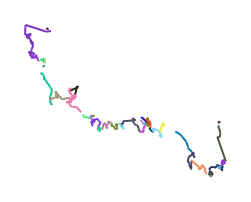

Generating sequence ...
storke shape (401, 3)


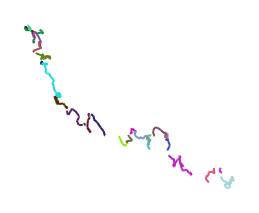

Generating sequence ...
storke shape (401, 3)


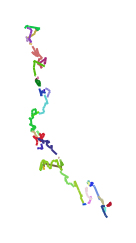

Generating sequence ...
storke shape (401, 3)


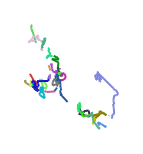

Generating sequence ...
storke shape (401, 3)


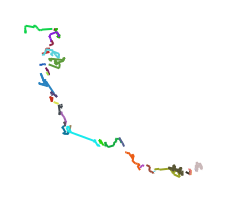

Epoch :  5  - step  10 / 344  - loss  -508.0140686035156  in  26.55558967590332
Epoch :  5  - step  20 / 344  - loss  -572.9510498046875  in  7.517158508300781
Epoch :  5  - step  30 / 344  - loss  -1449.641357421875  in  7.876208543777466
Epoch :  5  - step  40 / 344  - loss  -1503.316650390625  in  7.375923156738281
Epoch :  5  - step  50 / 344  - loss  415.4814758300781  in  7.550867080688477
Epoch :  5  - step  60 / 344  - loss  -152.11959838867188  in  7.7248640060424805
Epoch :  5  - step  70 / 344  - loss  -1080.732421875  in  7.86883282661438
Epoch :  5  - step  80 / 344  - loss  -427.3027038574219  in  7.164840459823608
Epoch :  5  - step  90 / 344  - loss  430.9548034667969  in  7.256190776824951
Epoch :  5  - step  100 / 344  - loss  -2170.3447265625  in  7.488618850708008
Epoch :  5  - step  110 / 344  - loss  -1049.6968994140625  in  7.775804281234741
Epoch :  5  - step  120 / 344  - loss  -445.4951171875  in  6.731779336929321
Epoch :  5  - step  130 / 344  - loss  -679.4

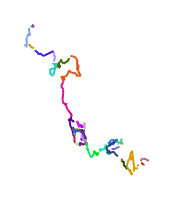

Generating sequence ...
storke shape (401, 3)


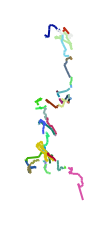

Generating sequence ...
storke shape (401, 3)


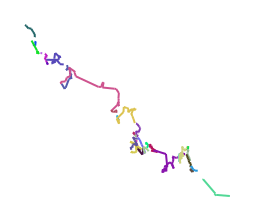

Generating sequence ...
storke shape (401, 3)


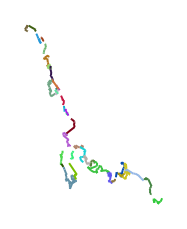

Generating sequence ...
storke shape (401, 3)


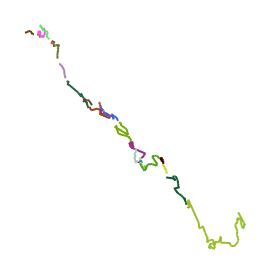

Epoch :  6  - step  10 / 344  - loss  29.802215576171875  in  27.500596046447754
Epoch :  6  - step  20 / 344  - loss  498.87677001953125  in  7.340373516082764
Epoch :  6  - step  30 / 344  - loss  2418.367431640625  in  7.172577381134033
Epoch :  6  - step  40 / 344  - loss  -1913.265380859375  in  8.097046136856079
Epoch :  6  - step  50 / 344  - loss  66.34625244140625  in  7.561947584152222
Epoch :  6  - step  60 / 344  - loss  -1804.8565673828125  in  8.100396871566772
Epoch :  6  - step  70 / 344  - loss  499.48394775390625  in  7.39874005317688
Epoch :  6  - step  80 / 344  - loss  511.27001953125  in  6.760169506072998
Epoch :  6  - step  90 / 344  - loss  1869.338623046875  in  6.991791248321533
Epoch :  6  - step  100 / 344  - loss  -1792.9813232421875  in  8.813645601272583
Epoch :  6  - step  110 / 344  - loss  -474.54022216796875  in  7.128101825714111
Epoch :  6  - step  120 / 344  - loss  -1985.35009765625  in  7.289114475250244
Epoch :  6  - step  130 / 344  - loss  15

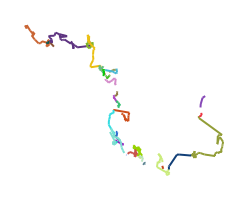

Generating sequence ...
storke shape (401, 3)


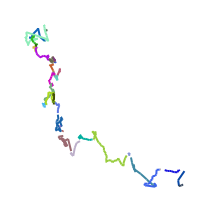

Generating sequence ...
storke shape (401, 3)


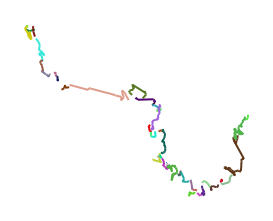

Generating sequence ...
storke shape (401, 3)


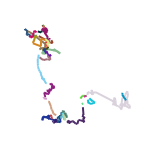

Generating sequence ...
storke shape (401, 3)


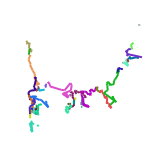

Epoch :  7  - step  10 / 344  - loss  -777.067626953125  in  25.674602508544922
Epoch :  7  - step  20 / 344  - loss  2352.8388671875  in  8.112261056900024
Epoch :  7  - step  30 / 344  - loss  -1056.0609130859375  in  7.00256085395813
Epoch :  7  - step  40 / 344  - loss  1125.03369140625  in  6.672174692153931
Epoch :  7  - step  50 / 344  - loss  -491.4508361816406  in  7.307598114013672
Epoch :  7  - step  60 / 344  - loss  -143.02789306640625  in  7.296817779541016
Epoch :  7  - step  70 / 344  - loss  -1649.62890625  in  7.991016864776611
Epoch :  7  - step  80 / 344  - loss  1794.177734375  in  6.899700164794922
Epoch :  7  - step  90 / 344  - loss  190.20877075195312  in  7.402811288833618
Epoch :  7  - step  100 / 344  - loss  -1412.508056640625  in  7.66498327255249
Epoch :  7  - step  110 / 344  - loss  2182.03857421875  in  7.492022752761841
Epoch :  7  - step  120 / 344  - loss  58.91624450683594  in  6.874160051345825
Epoch :  7  - step  130 / 344  - loss  -702.739013671

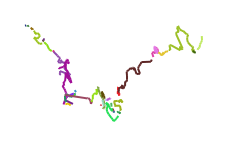

Generating sequence ...
storke shape (401, 3)


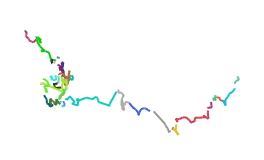

Generating sequence ...
storke shape (401, 3)


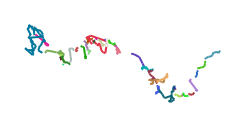

Generating sequence ...
storke shape (401, 3)


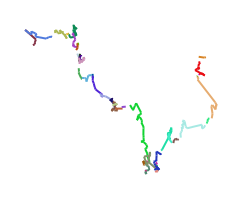

Generating sequence ...
storke shape (401, 3)


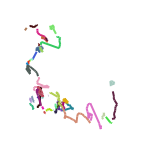

Epoch :  8  - step  10 / 344  - loss  -896.6438598632812  in  27.086655378341675
Epoch :  8  - step  20 / 344  - loss  -541.7068481445312  in  7.030846834182739
Epoch :  8  - step  30 / 344  - loss  2678.51513671875  in  7.427690505981445
Epoch :  8  - step  40 / 344  - loss  -682.5834350585938  in  7.0125203132629395
Epoch :  8  - step  50 / 344  - loss  -67.60205078125  in  8.060921669006348
Epoch :  8  - step  60 / 344  - loss  1123.4326171875  in  6.750150442123413
Epoch :  8  - step  70 / 344  - loss  -597.9818115234375  in  6.917176246643066
Epoch :  8  - step  80 / 344  - loss  -1492.6044921875  in  7.532779932022095
Epoch :  8  - step  90 / 344  - loss  16.668487548828125  in  7.285647869110107
Epoch :  8  - step  100 / 344  - loss  316.76025390625  in  7.331766843795776
Epoch :  8  - step  110 / 344  - loss  2665.6416015625  in  7.320149898529053
Epoch :  8  - step  120 / 344  - loss  625.3126831054688  in  7.742648601531982
Epoch :  8  - step  130 / 344  - loss  1788.18334960

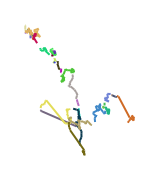

Generating sequence ...
storke shape (401, 3)


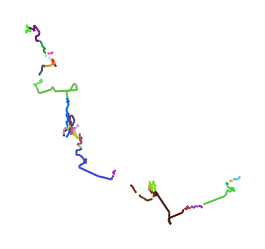

Generating sequence ...
storke shape (401, 3)


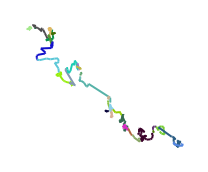

Generating sequence ...
storke shape (401, 3)


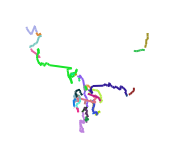

Generating sequence ...
storke shape (401, 3)


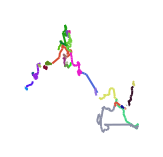

Epoch :  9  - step  10 / 344  - loss  69.27497863769531  in  26.565229892730713
Epoch :  9  - step  20 / 344  - loss  -183.6932373046875  in  7.05868673324585
Epoch :  9  - step  30 / 344  - loss  -20.47857666015625  in  8.01369857788086
Epoch :  9  - step  40 / 344  - loss  -319.26025390625  in  6.976008415222168
Epoch :  9  - step  50 / 344  - loss  -1544.796875  in  7.827138185501099
Epoch :  9  - step  60 / 344  - loss  903.166259765625  in  6.824196815490723
Epoch :  9  - step  70 / 344  - loss  -524.8583374023438  in  7.15448784828186
Epoch :  9  - step  80 / 344  - loss  -769.3361206054688  in  7.237825155258179
Epoch :  9  - step  90 / 344  - loss  180.95956420898438  in  7.249701738357544
Epoch :  9  - step  100 / 344  - loss  -1047.881591796875  in  7.4357686042785645
Epoch :  9  - step  110 / 344  - loss  -1265.761962890625  in  7.0243871212005615
Epoch :  9  - step  120 / 344  - loss  -533.0921630859375  in  7.601070404052734
Epoch :  9  - step  130 / 344  - loss  -1452.514

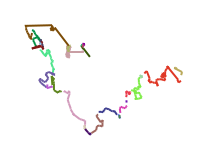

Generating sequence ...
storke shape (401, 3)


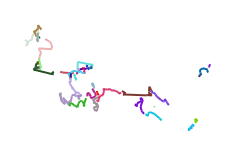

Generating sequence ...
storke shape (401, 3)


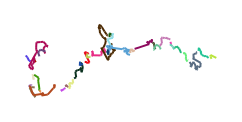

Generating sequence ...
storke shape (401, 3)


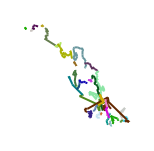

Generating sequence ...
storke shape (401, 3)


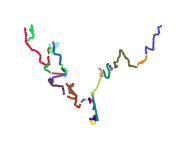

Epoch :  10  - step  10 / 344  - loss  -335.41015625  in  25.883705854415894
Epoch :  10  - step  20 / 344  - loss  -2539.98388671875  in  7.120081901550293
Epoch :  10  - step  30 / 344  - loss  -2744.441162109375  in  7.614273309707642
Epoch :  10  - step  40 / 344  - loss  -79.48583984375  in  7.501828193664551
Epoch :  10  - step  50 / 344  - loss  -2047.7645263671875  in  8.307924509048462
Epoch :  10  - step  60 / 344  - loss  -282.2168884277344  in  6.5432751178741455
Epoch :  10  - step  70 / 344  - loss  931.6328735351562  in  6.896087408065796
Epoch :  10  - step  80 / 344  - loss  -2236.97607421875  in  7.136115074157715
Epoch :  10  - step  90 / 344  - loss  -2206.318359375  in  6.830849885940552
Epoch :  10  - step  100 / 344  - loss  788.71337890625  in  7.558284044265747
Epoch :  10  - step  110 / 344  - loss  -1816.0572509765625  in  7.273306608200073
Epoch :  10  - step  120 / 344  - loss  -990.3805541992188  in  7.936890125274658
Epoch :  10  - step  130 / 344  - loss

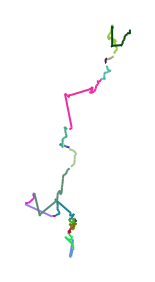

Generating sequence ...
storke shape (401, 3)


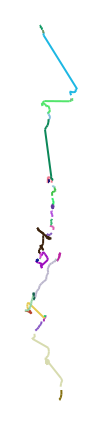

Generating sequence ...
storke shape (401, 3)


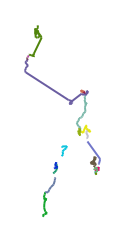

Generating sequence ...
storke shape (401, 3)


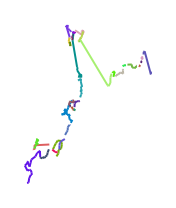

Generating sequence ...
storke shape (401, 3)


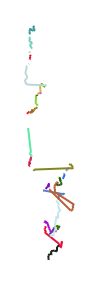

Epoch :  11  - step  10 / 344  - loss  70.26239013671875  in  26.845671892166138
Epoch :  11  - step  20 / 344  - loss  -1061.004638671875  in  7.230990886688232
Epoch :  11  - step  30 / 344  - loss  -1188.1021728515625  in  7.458000421524048
Epoch :  11  - step  40 / 344  - loss  -302.13671875  in  6.530910015106201
Epoch :  11  - step  50 / 344  - loss  -1546.760498046875  in  6.320925712585449
Epoch :  11  - step  60 / 344  - loss  -2108.32177734375  in  7.594960451126099
Epoch :  11  - step  70 / 344  - loss  -1515.67431640625  in  8.118765592575073
Epoch :  11  - step  80 / 344  - loss  -726.9677734375  in  7.498103857040405
Epoch :  11  - step  90 / 344  - loss  1026.1680908203125  in  7.379591464996338
Epoch :  11  - step  100 / 344  - loss  -1134.733642578125  in  7.254559755325317
Epoch :  11  - step  110 / 344  - loss  1118.96240234375  in  7.746028184890747
Epoch :  11  - step  120 / 344  - loss  -406.69549560546875  in  7.701511383056641
Epoch :  11  - step  130 / 344  - l

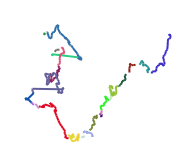

Generating sequence ...
storke shape (401, 3)


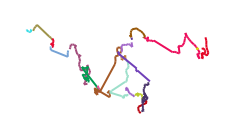

Generating sequence ...
storke shape (401, 3)


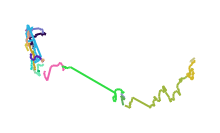

Generating sequence ...
storke shape (401, 3)


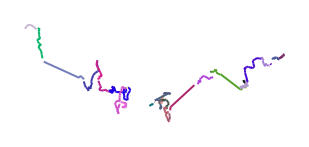

Generating sequence ...
storke shape (401, 3)


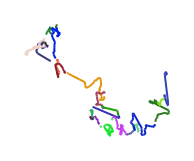

Epoch :  12  - step  10 / 344  - loss  -1279.659912109375  in  26.277342796325684
Epoch :  12  - step  20 / 344  - loss  -325.96099853515625  in  6.932482957839966
Epoch :  12  - step  30 / 344  - loss  -864.9032592773438  in  6.955872297286987
Epoch :  12  - step  40 / 344  - loss  -1316.875244140625  in  7.940121650695801
Epoch :  12  - step  50 / 344  - loss  -230.83673095703125  in  7.9950690269470215
Epoch :  12  - step  60 / 344  - loss  -1213.71435546875  in  7.557814598083496
Epoch :  12  - step  70 / 344  - loss  -1897.634033203125  in  7.4781575202941895
Epoch :  12  - step  80 / 344  - loss  -389.42694091796875  in  7.411968231201172
Epoch :  12  - step  90 / 344  - loss  44.0761604309082  in  6.634283781051636
Epoch :  12  - step  100 / 344  - loss  -259.2471618652344  in  7.30960750579834
Epoch :  12  - step  110 / 344  - loss  -246.98577880859375  in  7.187560796737671
Epoch :  12  - step  120 / 344  - loss  -667.0230712890625  in  7.644409894943237
Epoch :  12  - step  1

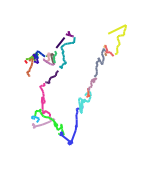

Generating sequence ...
storke shape (401, 3)


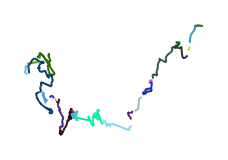

Generating sequence ...
storke shape (401, 3)


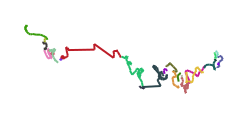

Generating sequence ...
storke shape (401, 3)


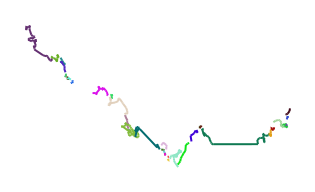

Generating sequence ...
storke shape (401, 3)


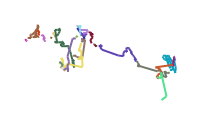

Epoch :  13  - step  10 / 344  - loss  -1987.8138427734375  in  27.372771739959717
Epoch :  13  - step  20 / 344  - loss  -1995.1624755859375  in  6.833633184432983
Epoch :  13  - step  30 / 344  - loss  -2271.28466796875  in  8.224656105041504
Epoch :  13  - step  40 / 344  - loss  -356.09893798828125  in  7.227522134780884
Epoch :  13  - step  50 / 344  - loss  -474.5669250488281  in  7.709754705429077
Epoch :  13  - step  60 / 344  - loss  -1444.966064453125  in  7.178754568099976
Epoch :  13  - step  70 / 344  - loss  121.09040832519531  in  7.540639638900757
Epoch :  13  - step  80 / 344  - loss  -476.74371337890625  in  7.576664686203003
Epoch :  13  - step  90 / 344  - loss  -1299.8544921875  in  7.806177854537964
Epoch :  13  - step  100 / 344  - loss  -174.3008270263672  in  7.141658067703247
Epoch :  13  - step  110 / 344  - loss  -1580.61962890625  in  7.964500188827515
Epoch :  13  - step  120 / 344  - loss  -1026.7567138671875  in  7.4310595989227295
Epoch :  13  - step  1

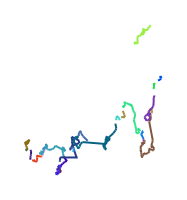

Generating sequence ...
storke shape (401, 3)


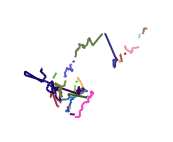

Generating sequence ...
storke shape (401, 3)


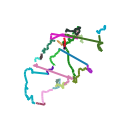

Generating sequence ...
storke shape (401, 3)


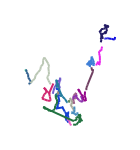

Generating sequence ...
storke shape (401, 3)


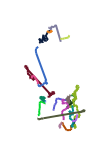

Epoch :  14  - step  10 / 344  - loss  -1821.1827392578125  in  25.995291471481323
Epoch :  14  - step  20 / 344  - loss  -2023.1953125  in  8.194742918014526
Epoch :  14  - step  30 / 344  - loss  -1618.4208984375  in  7.416501522064209
Epoch :  14  - step  40 / 344  - loss  -1609.589111328125  in  7.615509748458862
Epoch :  14  - step  50 / 344  - loss  -2452.642578125  in  7.515271902084351
Epoch :  14  - step  60 / 344  - loss  -1631.46630859375  in  7.155886173248291
Epoch :  14  - step  70 / 344  - loss  -2144.856201171875  in  7.992942571640015
Epoch :  14  - step  80 / 344  - loss  -808.6602172851562  in  8.127721071243286
Epoch :  14  - step  90 / 344  - loss  -1327.84423828125  in  7.897129774093628
Epoch :  14  - step  100 / 344  - loss  -872.9481201171875  in  6.677983999252319
Epoch :  14  - step  110 / 344  - loss  -3151.1064453125  in  8.31580924987793
Epoch :  14  - step  120 / 344  - loss  -1469.8609619140625  in  7.059952735900879
Epoch :  14  - step  130 / 344  - los

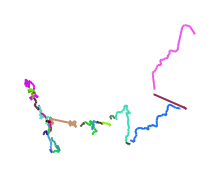

Generating sequence ...
storke shape (401, 3)


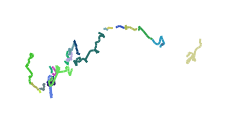

Generating sequence ...
storke shape (401, 3)


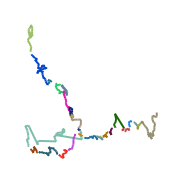

Generating sequence ...
storke shape (401, 3)


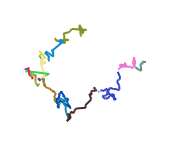

Generating sequence ...
storke shape (401, 3)


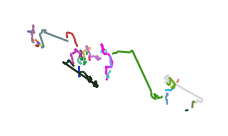

Epoch :  15  - step  10 / 344  - loss  -363.7529296875  in  27.073768138885498
Epoch :  15  - step  20 / 344  - loss  -35.18067169189453  in  7.11433482170105
Epoch :  15  - step  30 / 344  - loss  973.5938720703125  in  7.377104043960571
Epoch :  15  - step  40 / 344  - loss  -1702.19140625  in  7.173021078109741
Epoch :  15  - step  50 / 344  - loss  513.907958984375  in  7.7822511196136475
Epoch :  15  - step  60 / 344  - loss  -1805.5810546875  in  7.726636171340942
Epoch :  15  - step  70 / 344  - loss  -1299.589111328125  in  7.208211660385132
Epoch :  15  - step  80 / 344  - loss  -844.13818359375  in  7.509531497955322
Epoch :  15  - step  90 / 344  - loss  -1967.9342041015625  in  8.174807071685791
Epoch :  15  - step  100 / 344  - loss  -2406.732177734375  in  7.762128829956055
Epoch :  15  - step  110 / 344  - loss  -1162.70458984375  in  7.145555734634399
Epoch :  15  - step  120 / 344  - loss  -1171.06640625  in  7.05598258972168
Epoch :  15  - step  130 / 344  - loss  -13

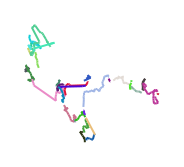

Generating sequence ...
storke shape (401, 3)


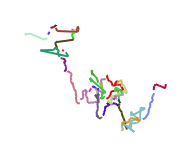

Generating sequence ...
storke shape (401, 3)


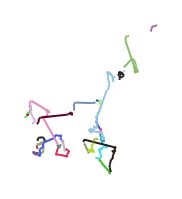

Generating sequence ...
storke shape (401, 3)


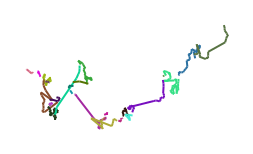

Generating sequence ...
storke shape (401, 3)


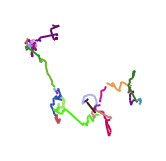

Epoch :  16  - step  10 / 344  - loss  -1599.03125  in  25.979036808013916
Epoch :  16  - step  20 / 344  - loss  -668.7305297851562  in  8.036564826965332
Epoch :  16  - step  30 / 344  - loss  -641.73388671875  in  6.588818073272705
Epoch :  16  - step  40 / 344  - loss  -1805.815185546875  in  7.876727104187012
Epoch :  16  - step  50 / 344  - loss  -228.32151794433594  in  7.716557264328003
Epoch :  16  - step  60 / 344  - loss  -2644.0087890625  in  7.574138641357422
Epoch :  16  - step  70 / 344  - loss  1537.4429931640625  in  6.827410936355591
Epoch :  16  - step  80 / 344  - loss  2052.539306640625  in  7.589785575866699
Epoch :  16  - step  90 / 344  - loss  -600.8802490234375  in  6.586867809295654
Epoch :  16  - step  100 / 344  - loss  -1817.29345703125  in  6.846166372299194
Epoch :  16  - step  110 / 344  - loss  758.45654296875  in  7.6118247509002686
Epoch :  16  - step  120 / 344  - loss  130.1075439453125  in  7.84645938873291
Epoch :  16  - step  130 / 344  - loss  

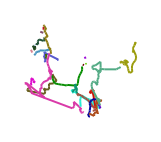

Generating sequence ...
storke shape (401, 3)


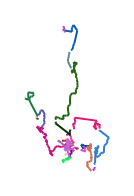

Generating sequence ...
storke shape (401, 3)


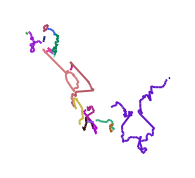

Generating sequence ...
storke shape (401, 3)


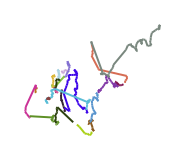

Generating sequence ...
storke shape (401, 3)


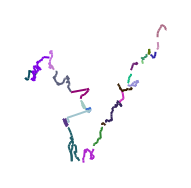

Epoch :  17  - step  10 / 344  - loss  -1633.9293212890625  in  26.25558352470398
Epoch :  17  - step  20 / 344  - loss  -1070.8961181640625  in  7.076104402542114
Epoch :  17  - step  30 / 344  - loss  -1992.5697021484375  in  7.527923583984375
Epoch :  17  - step  40 / 344  - loss  -210.25692749023438  in  7.239204406738281
Epoch :  17  - step  50 / 344  - loss  -2205.905029296875  in  7.484247446060181
Epoch :  17  - step  60 / 344  - loss  -987.3646850585938  in  7.157262802124023
Epoch :  17  - step  70 / 344  - loss  -1282.8125  in  7.809567928314209
Epoch :  17  - step  80 / 344  - loss  -328.8202209472656  in  6.914477586746216
Epoch :  17  - step  90 / 344  - loss  -1264.08251953125  in  6.9643714427948
Epoch :  17  - step  100 / 344  - loss  -889.92724609375  in  7.574903726577759
Epoch :  17  - step  110 / 344  - loss  -1611.4952392578125  in  7.459891080856323
Epoch :  17  - step  120 / 344  - loss  -882.7230224609375  in  7.501262187957764
Epoch :  17  - step  130 / 344  -

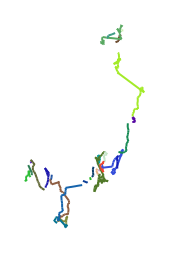

Generating sequence ...
storke shape (401, 3)


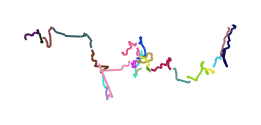

Generating sequence ...
storke shape (401, 3)


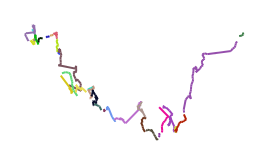

Generating sequence ...
storke shape (401, 3)


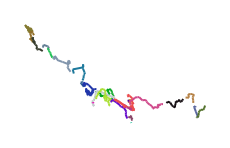

Generating sequence ...
storke shape (401, 3)


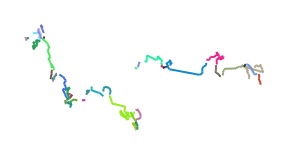

Epoch :  18  - step  10 / 344  - loss  -2045.84375  in  27.112069368362427
Epoch :  18  - step  20 / 344  - loss  -1667.290283203125  in  7.484264135360718
Epoch :  18  - step  30 / 344  - loss  -135.01063537597656  in  7.148435831069946
Epoch :  18  - step  40 / 344  - loss  -1080.9912109375  in  7.611014366149902
Epoch :  18  - step  50 / 344  - loss  -1108.71337890625  in  7.2910988330841064
Epoch :  18  - step  60 / 344  - loss  -2103.05126953125  in  7.516859769821167
Epoch :  18  - step  70 / 344  - loss  -1714.08544921875  in  7.575810670852661
Epoch :  18  - step  80 / 344  - loss  -2706.68115234375  in  7.740045070648193
Epoch :  18  - step  90 / 344  - loss  -3055.55224609375  in  7.999159336090088
Epoch :  18  - step  100 / 344  - loss  -1990.495361328125  in  7.337103366851807
Epoch :  18  - step  110 / 344  - loss  -1441.6982421875  in  7.453478574752808
Epoch :  18  - step  120 / 344  - loss  -2018.0025634765625  in  7.018406391143799
Epoch :  18  - step  130 / 344  - los

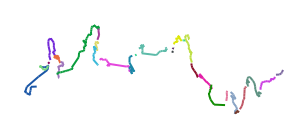

Generating sequence ...
storke shape (401, 3)


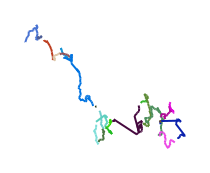

Generating sequence ...
storke shape (401, 3)


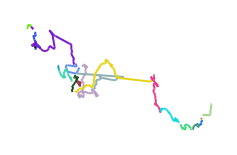

Generating sequence ...
storke shape (401, 3)


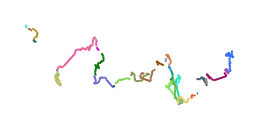

Generating sequence ...
storke shape (401, 3)


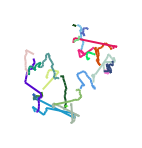

Epoch :  19  - step  10 / 344  - loss  -677.5574951171875  in  26.697165489196777
Epoch :  19  - step  20 / 344  - loss  -677.7667236328125  in  7.275779724121094
Epoch :  19  - step  30 / 344  - loss  -1182.4498291015625  in  6.849266767501831
Epoch :  19  - step  40 / 344  - loss  -2786.47314453125  in  7.721556663513184
Epoch :  19  - step  50 / 344  - loss  -1250.1373291015625  in  7.026262521743774
Epoch :  19  - step  60 / 344  - loss  -3409.055419921875  in  7.314273357391357
Epoch :  19  - step  70 / 344  - loss  -2107.509765625  in  7.917622089385986
Epoch :  19  - step  80 / 344  - loss  -1619.427001953125  in  7.477888345718384
Epoch :  19  - step  90 / 344  - loss  -1839.9423828125  in  7.310598373413086
Epoch :  19  - step  100 / 344  - loss  -2808.83984375  in  7.506474494934082
Epoch :  19  - step  110 / 344  - loss  -1995.6153564453125  in  7.705540657043457
Epoch :  19  - step  120 / 344  - loss  -2855.7275390625  in  7.214859485626221
Epoch :  19  - step  130 / 344  -

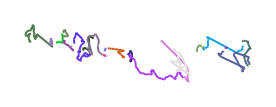

Generating sequence ...
storke shape (401, 3)


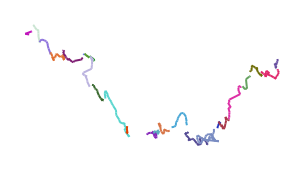

Generating sequence ...
storke shape (401, 3)


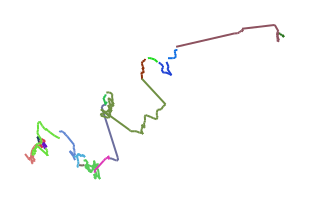

Generating sequence ...
storke shape (401, 3)


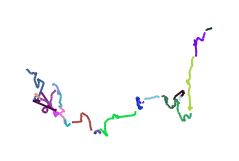

Generating sequence ...
storke shape (401, 3)


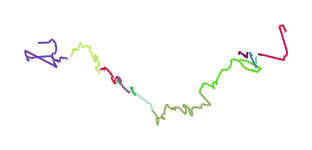

Epoch :  20  - step  10 / 344  - loss  -1858.0687255859375  in  27.73543882369995
Epoch :  20  - step  20 / 344  - loss  -3271.6259765625  in  7.750101327896118
Epoch :  20  - step  30 / 344  - loss  -643.4139404296875  in  6.609680891036987
Epoch :  20  - step  40 / 344  - loss  -2940.59716796875  in  7.14543890953064
Epoch :  20  - step  50 / 344  - loss  -982.0921630859375  in  7.861248016357422
Epoch :  20  - step  60 / 344  - loss  -2217.58251953125  in  7.0354228019714355
Epoch :  20  - step  70 / 344  - loss  -1073.4737548828125  in  7.719194412231445
Epoch :  20  - step  80 / 344  - loss  -1660.3157958984375  in  7.42738938331604
Epoch :  20  - step  90 / 344  - loss  -2623.841796875  in  7.61797022819519
Epoch :  20  - step  100 / 344  - loss  -1652.08349609375  in  7.006820201873779
Epoch :  20  - step  110 / 344  - loss  -2161.69873046875  in  7.766330003738403
Epoch :  20  - step  120 / 344  - loss  -1322.968505859375  in  7.346755743026733
Epoch :  20  - step  130 / 344  -

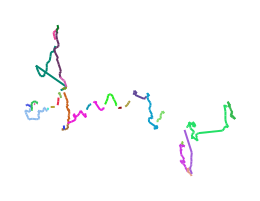

Generating sequence ...
storke shape (401, 3)


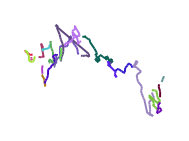

Generating sequence ...
storke shape (401, 3)


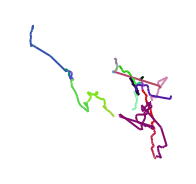

Generating sequence ...
storke shape (401, 3)


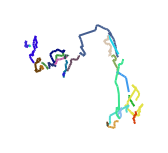

Generating sequence ...
storke shape (401, 3)


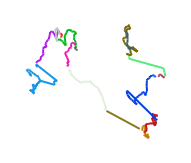

Epoch :  21  - step  10 / 344  - loss  -1649.90380859375  in  25.906858205795288
Epoch :  21  - step  20 / 344  - loss  -3063.179443359375  in  7.2118752002716064
Epoch :  21  - step  30 / 344  - loss  -3064.0341796875  in  7.6140642166137695
Epoch :  21  - step  40 / 344  - loss  -1051.30029296875  in  7.1207311153411865
Epoch :  21  - step  50 / 344  - loss  -2337.7509765625  in  7.504597187042236
Epoch :  21  - step  60 / 344  - loss  -2675.62158203125  in  7.614320278167725
Epoch :  21  - step  70 / 344  - loss  -579.7137451171875  in  6.861169099807739
Epoch :  21  - step  80 / 344  - loss  -3693.896484375  in  7.778212070465088
Epoch :  21  - step  90 / 344  - loss  -1088.145751953125  in  7.733735799789429
Epoch :  21  - step  100 / 344  - loss  -801.7147216796875  in  7.027651786804199
Epoch :  21  - step  110 / 344  - loss  -1660.167724609375  in  7.266998291015625
Epoch :  21  - step  120 / 344  - loss  -1508.12109375  in  7.286836385726929
Epoch :  21  - step  130 / 344  - l

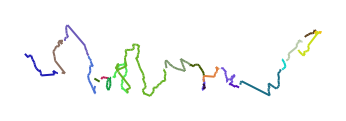

Generating sequence ...
storke shape (401, 3)


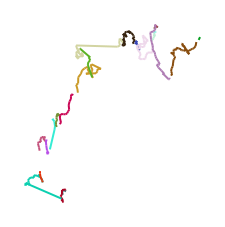

Generating sequence ...
storke shape (401, 3)


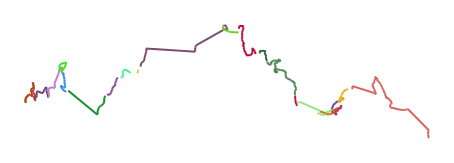

Generating sequence ...
storke shape (401, 3)


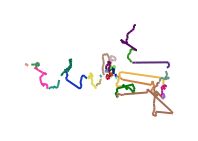

Generating sequence ...
storke shape (401, 3)


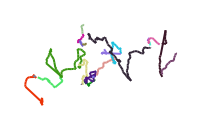

Epoch :  22  - step  10 / 344  - loss  -3203.67138671875  in  26.641456127166748
Epoch :  22  - step  20 / 344  - loss  -952.5311889648438  in  7.3741443157196045
Epoch :  22  - step  30 / 344  - loss  -3115.4150390625  in  7.183995723724365
Epoch :  22  - step  40 / 344  - loss  -1332.565185546875  in  6.887298822402954
Epoch :  22  - step  50 / 344  - loss  -2226.57763671875  in  7.278107404708862
Epoch :  22  - step  60 / 344  - loss  -1773.61279296875  in  6.758753538131714
Epoch :  22  - step  70 / 344  - loss  -2345.663818359375  in  7.195925235748291
Epoch :  22  - step  80 / 344  - loss  -1603.2091064453125  in  7.19779109954834
Epoch :  22  - step  90 / 344  - loss  -1318.17333984375  in  6.6125311851501465
Epoch :  22  - step  100 / 344  - loss  -1592.3021240234375  in  7.219924449920654
Epoch :  22  - step  110 / 344  - loss  -2705.294921875  in  7.747083902359009
Epoch :  22  - step  120 / 344  - loss  -2396.5810546875  in  7.97550368309021
Epoch :  22  - step  130 / 344  -

In [ ]:
torch.cuda.empty_cache()
model = TFHW_GMX()
# model.load_state_dict(torch.load("./models/synthesis.py"))
# model.eval()

model = train_network(model, epochs = 50, generate = True)